In [ ]:
import torch
import timm
import time
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
data_dir = '/kaggle/input/maizda/maizdataset'

# Set up data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset and split into training and validation sets
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Splitting dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Print class names to verify
print("Classes:", dataset.classes)

Classes: ['HEATHLY', 'MLN_1_and_MLN_2', 'MSV_1', 'MSV_2']


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('mobilevit_s', pretrained=True, num_classes=len(dataset.classes))
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Function to calculate GPU memory usage
def get_gpu_memory_usage():
    return torch.cuda.memory_allocated() / (1024 * 1024)  # in MB

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training setup variables
num_epochs = 30
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []  # Corrected initialization
gpu_memory_usage = []
time_per_epoch = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    end_time = time.time()
    time_per_epoch.append(end_time - start_time)

    # Track GPU memory usage
    gpu_memory_usage.append(torch.cuda.memory_allocated() / (1024 * 1024))
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Time: {end_time - start_time:.2f}s')


Epoch 1/30, Train Loss: 0.4450, Train Acc: 87.43%, Val Loss: 0.1770, Val Acc: 93.13%, Time: 79.25s
Epoch 2/30, Train Loss: 0.1948, Train Acc: 92.60%, Val Loss: 0.1617, Val Acc: 93.36%, Time: 79.50s
Epoch 3/30, Train Loss: 0.1535, Train Acc: 93.99%, Val Loss: 0.2109, Val Acc: 90.72%, Time: 79.14s
Epoch 4/30, Train Loss: 0.1301, Train Acc: 95.12%, Val Loss: 0.1546, Val Acc: 93.65%, Time: 79.09s
Epoch 5/30, Train Loss: 0.1103, Train Acc: 95.95%, Val Loss: 0.1943, Val Acc: 93.03%, Time: 79.44s
Epoch 6/30, Train Loss: 0.0870, Train Acc: 96.64%, Val Loss: 0.1848, Val Acc: 93.55%, Time: 79.50s
Epoch 7/30, Train Loss: 0.0710, Train Acc: 97.49%, Val Loss: 0.3221, Val Acc: 91.07%, Time: 79.91s
Epoch 8/30, Train Loss: 0.0584, Train Acc: 97.96%, Val Loss: 0.2014, Val Acc: 93.03%, Time: 79.39s
Epoch 9/30, Train Loss: 0.0378, Train Acc: 98.68%, Val Loss: 0.2587, Val Acc: 93.09%, Time: 79.90s
Epoch 10/30, Train Loss: 0.0368, Train Acc: 98.66%, Val Loss: 0.2015, Val Acc: 94.04%, Time: 79.37s
Epoch 11/

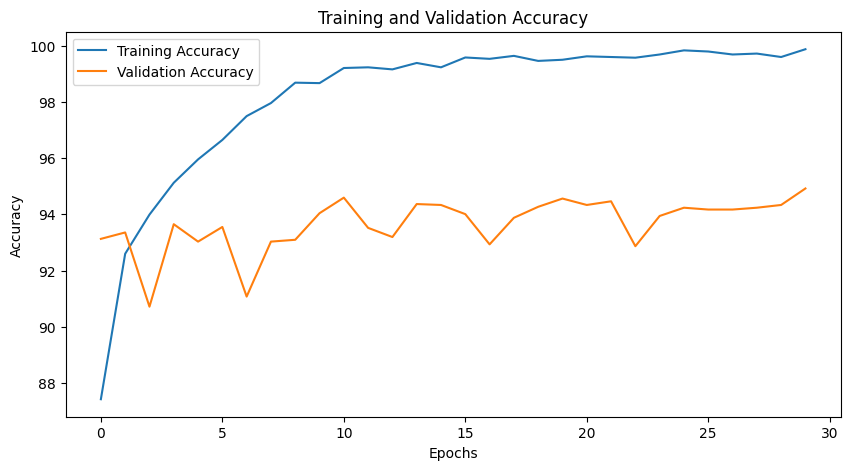

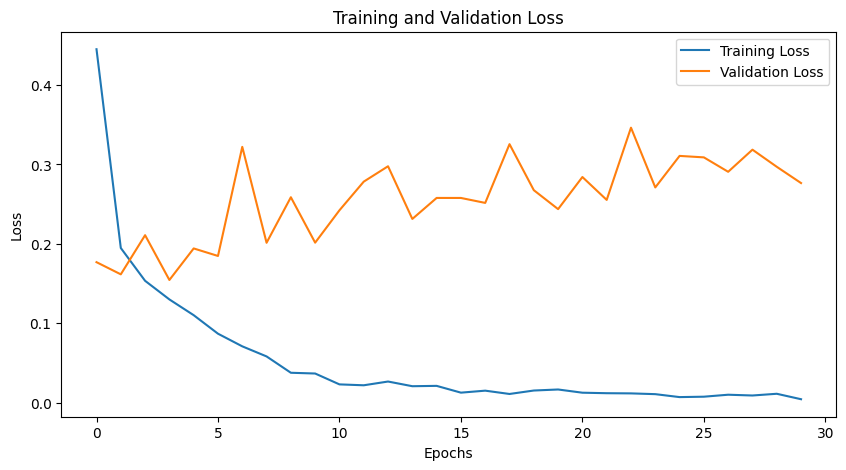

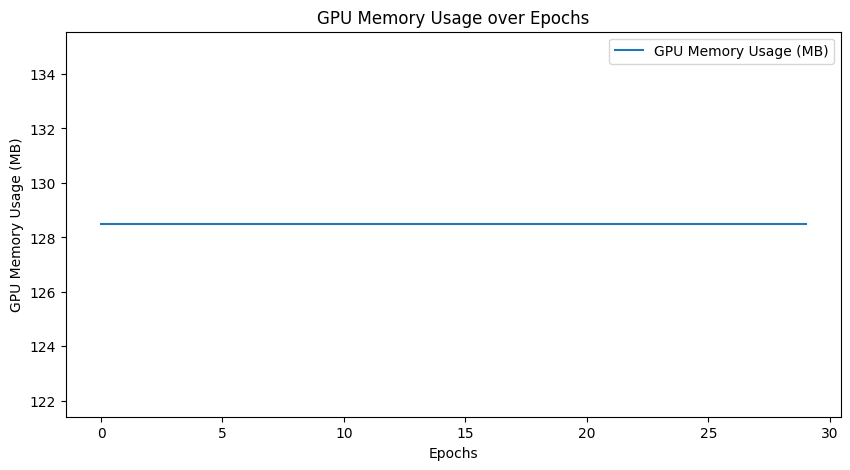

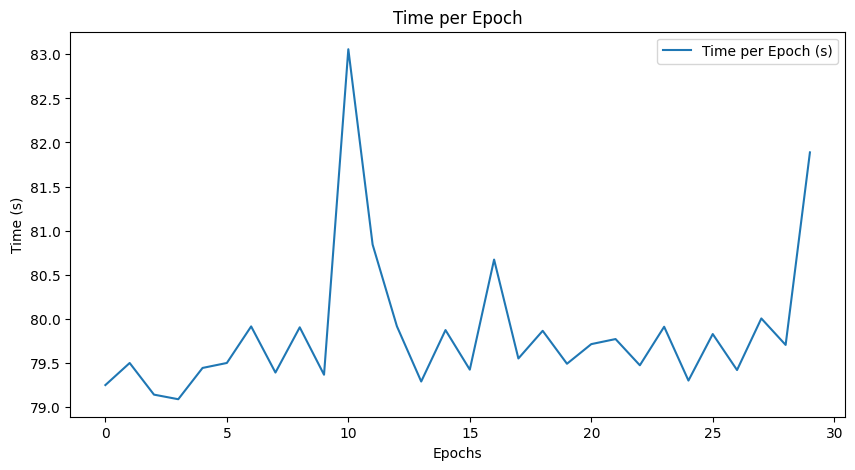

In [ ]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot GPU Memory Usage per epoch
plt.figure(figsize=(10, 5))
plt.plot(gpu_memory_usage, label='GPU Memory Usage (MB)')
plt.xlabel('Epochs')
plt.ylabel('GPU Memory Usage (MB)')
plt.title('GPU Memory Usage over Epochs')
plt.legend()
plt.show()

# Plot time per epoch
plt.figure(figsize=(10, 5))
plt.plot(time_per_epoch, label='Time per Epoch (s)')
plt.xlabel('Epochs')
plt.ylabel('Time (s)')
plt.title('Time per Epoch')
plt.legend()
plt.show()


In [ ]:
# Classification report and confusion matrix on validation set
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
class_report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print("Classification Report:\n", class_report)


Classification Report:
                  precision    recall  f1-score   support

        HEATHLY       0.99      1.00      1.00      1052
MLN_1_and_MLN_2       0.99      0.99      0.99       779
          MSV_1       0.88      0.89      0.88       616
          MSV_2       0.89      0.87      0.88       623

       accuracy                           0.95      3070
      macro avg       0.94      0.94      0.94      3070
   weighted avg       0.95      0.95      0.95      3070



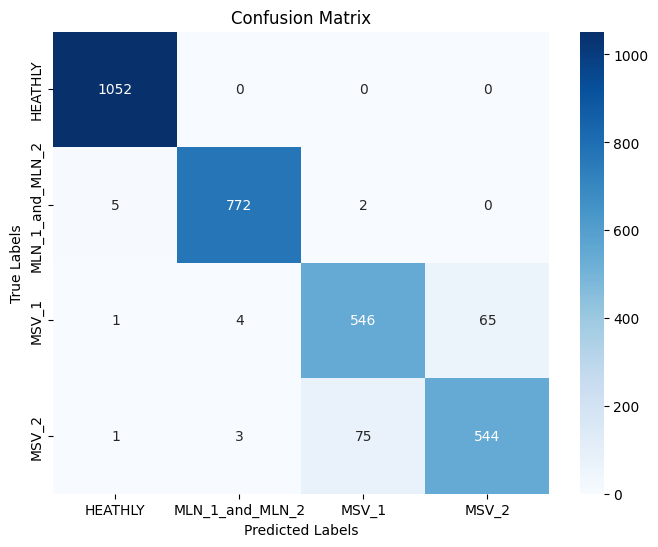

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

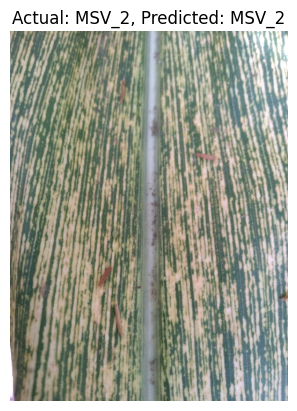

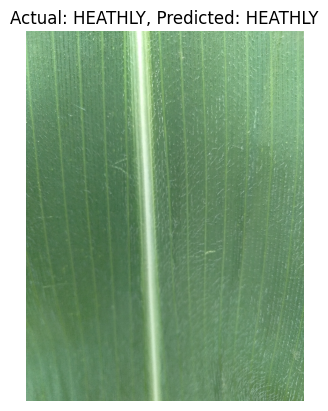

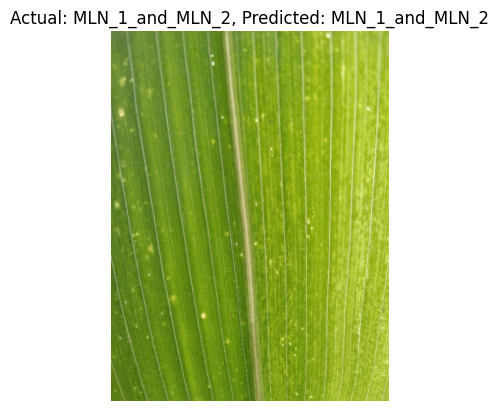

In [ ]:
import random
# Function to display the image with predicted and actual labels
def display_image_with_prediction(image_path, actual_label, predicted_label):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Choose three random images from the validation dataset
samples = random.sample(val_dataset.indices, 3)

# Model must be in evaluation mode
model.eval()

for sample in samples:
    # Get the actual image path and label
    actual_img, actual_label = dataset.imgs[sample]
    actual_class = dataset.classes[actual_label]

    # Load and transform the image
    img = transform(Image.open(actual_img).convert("RGB")).unsqueeze(0).to(device)

    # Predict the class using the trained model
    with torch.no_grad():
        outputs = model(img)
        _, predicted_label = torch.max(outputs, 1)
        predicted_class = dataset.classes[predicted_label.item()]

    # Display the image with actual and predicted labels
    display_image_with_prediction(actual_img, actual_class, predicted_class)
